In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pickle
import json
import itertools
from tqdm import tqdm_notebook
from IPython.display import clear_output

from kleinberg_experiment import *
plt.style.use('seaborn')

# Upload the data into memory

We use the dataset of primary school contacts first (from Sociopatterns). We use the dataset provided by Kleinberg et al. Below we upload the simplices to the memory.

In [2]:
dataset = "contact-primary-school"
data_dir = "./data/kleinberg/{}/".format(dataset)
simplex_file = "{}-simplices.txt".format(dataset)
size_file = "{}-nverts.txt".format(dataset)

simplexf = open(data_dir + simplex_file, 'r')
sizef = open(data_dir + size_file, 'r')

In [3]:
simplex_sizes = []
for s in tqdm_notebook(sizef):
    ss = s.strip()
    simplex_sizes.append(int(ss))

In [4]:
node_list = set([])
simplex_list = []
exceptions = []
cut_size = 1000000
for s in tqdm_notebook(simplex_sizes):
    one_simplex = []
    for i in range(s):
        rl = simplexf.readline()
        n = rl.strip()
        try:
            one_simplex.append(int(n))
            node_list.add(int(n))
        except:
            exceptions.append(rl)
    simplex_list.append(frozenset(one_simplex))
    if len(simplex_list) > cut_size:
        break
print("Exceptions:", len(exceptions))


Exceptions: 0


Kleinberg's sets their experiment as follows. On the first 80% of data they find the set of *open* triangles, i.e. the triangles in the projected graph (the one you obtain by projecting all interactions) which have all edges participating in some cliques, but not all three together in one clique. 

Then on the test set, they make a prediction  which open triangles from the test set will close (there will appear a clique containing this triangle). 

They compare their prediction with random null model, where each clique has independent probability to close which is equal to the number of closed triangles/total number of open triangles. 

The measure they compare is the AUC PR (area under the precision-recall curve), relative to AUC PR of the random null model. 

# Find open triangles

Split the set of all simplices to train set (first 80%) and test set (rest 20%).

In [5]:
threshold = int(0.8*len(simplex_list))
train_simplices = simplex_list[:threshold]
test_simplices = simplex_list[threshold:]

Find all closed and open triangles in the train and test set

In [6]:
g_train = get_projected_graph(train_simplices, info = True)
open_train, closed_train = get_open_closed_triangles(g_train, info = True)


Name: 
Type: Graph
Number of nodes: 242
Number of edges: 7575
Average degree:  62.6033



Open: 80447, Closed: 4258


In [7]:
g_total = get_projected_graph(simplex_list, info = True)
open_total, closed_total = get_open_closed_triangles(g_total, info = True)


Name: 
Type: Graph
Number of nodes: 242
Number of edges: 8317
Average degree:  68.7355



Open: 98621, Closed: 5139


Look which triangles have closed

In [8]:
closed_test = [t for t in closed_total if t in open_train]
print(len(closed_test))

685


In [112]:
y_test = [1 if t in closed_test else 0 for t in open_train]
print(len(y_test))
y_rnd_prob = [len(closed_test)/len(open_train)]*len(y_test)
print(sum(y_rnd_prob))

80447
684.9999999999158


# Simplex2Vec  test

Launch and train the Simplex2Vec model. 

In [9]:
import clusim.sim as sim
from clusim.clustering import Clustering
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.manifold import TSNE

from Simplex2Vec.Simplex2Vec import Simplex2Vec
from Simplex2Vec.utils import check_prediction
from Simplex2Vec.utils import read_simplex_json
from Simplex2Vec.simplex2hasse import simplex2hasse_HOexponential


g_hasse = simplex2hasse_HOexponential(train_simplices, max_order=5)
print(nx.info(g_hasse))

DendroPY not supported.



Name: 
Type: Graph
Number of nodes: 12394
Number of edges: 29209
Average degree:   4.7134


In [182]:
s2v = Simplex2Vec.from_hasse_diagram(g_hasse, p = 10**10, n_walks=30, 
                                     walk_length=120, workers = 3)




DONE!


In [179]:
class EpochShowLoss():
    '''Callback to show training loss after each epoch '''

    def __init__(self):
        self.epoch = 0
    
    def on_train_begin(self, model):
        pass
    def on_train_end(self, model):
        pass
    def on_epoch_begin(self, model):
        pass
    def on_batch_begin(self, model):
        pass
    def on_batch_end(self, model):
        pass
        
    def on_epoch_end(self, model):
        print("Epoch {} - Model loss: {}".format(self.epoch,
                                              model.get_latest_training_loss()))
        model_loss.append((self.epoch, model.get_latest_training_loss()))
        self.epoch += 1
model_loss = []
model = s2v.fit(iter = 3, callbacks = [EpochShowLoss()])
# for _ in range(20):  
#     model = s2v.refit(epochs = 1, callbacks = [EpochShowLoss()])
    

Fitting the Word2Vec..
Epoch 0 - Model loss: 2360180.25
Epoch 1 - Model loss: 3363936.25
Epoch 2 - Model loss: 4239066.0


## Plot the embedding

Extract the embedding vectors for nodes or edges and plot it on the plane using tSNE embedding.

In [180]:
X = []
X_labels = []

for u in model.wv.vocab.keys():
    if len(u.split(',')) == 1: # get all embedding vectors 
        X.append(model[u])
        
X_transform = TSNE(n_components=2).fit_transform(X)

/Users/amedvede/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


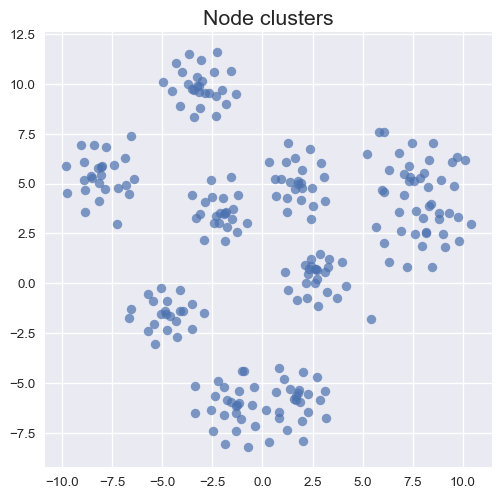

In [181]:
fig = plt.figure(figsize = (6,6), dpi = 96)
# colors_list = cm.nipy_spectral(np.asarray(pred_cluster_labels).astype(float) / num_classes)
plt.scatter(*zip(*X_transform), marker='o', s=50, lw=0, alpha=0.7,)
#                      c = colors_list)
text_params = {'ha': 'center', 'va': 'center', 'family': 'oswald-light',
                   'fontweight': 'normal', "size": 12}
# for i, z in enumerate(Z_labels):
#     x,y = X_transform[i]
#     plt.text(x,y, z, color = "black", alpha=0.8)

plt.title("Node clusters", fontsize = 16)
plt.show()

# Scoring the closing triangles - v1

Now we test the predictive model based on cosine similarity. The idea is simple: if an open triangle has all nodes that have high cosine similarity to each other, then this triangle is highly likely to close in future. We use simple sum of all three similarities as a decision function.

In v1 we use the similarity of pairs of nodes in a triangle.

In [199]:
from sklearn.metrics import average_precision_score, roc_auc_score, auc, f1_score
closure_similarity = []
for t in tqdm_notebook(open_train):
    similarity_scores = []
    for u,v in itertools.combinations(t,2):
        uf = str(u)
        vf = str(v)
        similarity_scores.append(model.wv.similarity(uf,vf))
    closure_similarity.append(np.sum(similarity_scores))
  
print(len(closure_similarity))


80447


AUCPR RND: 0.008514922868472411 | AUCPR S2V: 0.020473234008794677
Ratio as in Kleinberg --  AUCPR S2V/AUCPR RND : 2.404394534752562


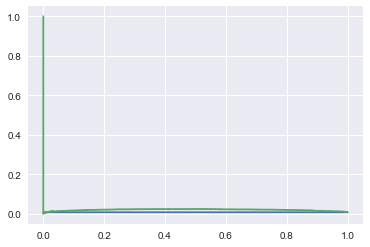

In [200]:
s2v_precision, s2v_recall, _ = precision_recall_curve(y_test, closure_similarity)

p = len([y for y in y_test if y == 1])/len(y_test)
rnd_precision = [p]*len(s2v_recall)

s2v_precision, s2v_recall = s2v_precision[::-1], s2v_recall[::-1]

aucpr_rnd = auc(s2v_recall, rnd_precision)
aucpr_s2v = auc(s2v_recall, s2v_precision)

print("AUCPR RND: {} | AUCPR S2V: {}".format(aucpr_rnd, aucpr_s2v))
kleinberg_ratio = aucpr_s2v/aucpr_rnd
print("Ratio as in Kleinberg --  AUCPR S2V/AUCPR RND :", kleinberg_ratio)

plt.plot(s2v_recall, rnd_precision)
plt.plot(s2v_recall, s2v_precision)
plt.show()

In [100]:
print(roc_auc_score(y_test, y_rnd_prob), roc_auc_score(y_test, closure_similarity))
print(f1_score(y_test, y_rnd_prob))

0.5 0.7726114387382755


ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [120]:
for clos_sim, y_t in list(zip(closure_similarity,y_test)):
    if y_t == 1:
        print(round(clos_sim, 2), y_t)

0.44 1
1.1 1
0.78 1
0.99 1
1.14 1
0.96 1
1.12 1
1.17 1
1.25 1
0.76 1
1.25 1
0.97 1
1.18 1
0.27 1
1.43 1
0.87 1
1.11 1
1.4 1
1.38 1
0.84 1
0.82 1
1.0 1
1.0 1
1.15 1
1.13 1
0.96 1
0.98 1
1.08 1
0.91 1
1.3 1
0.98 1
1.67 1
1.68 1
1.17 1
1.66 1
1.26 1
0.95 1
1.1 1
1.13 1
1.02 1
0.78 1
0.78 1
0.73 1
0.45 1
1.82 1
0.95 1
1.82 1
0.51 1
1.42 1
0.37 1
0.53 1
1.18 1
1.12 1
1.46 1
1.54 1
0.83 1
0.95 1
1.17 1
0.66 1
1.26 1
0.11 1
0.32 1
0.56 1
0.94 1
0.71 1
1.33 1
1.11 1
1.03 1
0.67 1
1.03 1
1.08 1
1.43 1
0.77 1
1.03 1
1.39 1
0.86 1
1.64 1
1.02 1
0.78 1
1.38 1
0.22 1
0.82 1
1.11 1
1.32 1
0.59 1
1.05 1
1.46 1
1.41 1
1.9 1
1.27 1
1.55 1
1.33 1
1.78 1
0.81 1
1.49 1
1.09 1
0.66 1
0.9 1
0.54 1
0.99 1
1.63 1
0.83 1
0.34 1
0.81 1
1.2 1
1.05 1
0.4 1
0.84 1
0.8 1
0.66 1
1.24 1
1.03 1
1.13 1
1.26 1
1.02 1
0.95 1
1.57 1
1.63 1
1.45 1
1.04 1
1.16 1
1.39 1
1.58 1
0.69 1
1.1 1
0.86 1
1.21 1
1.14 1
1.52 1
0.79 1
0.32 1
0.84 1
0.89 1
1.48 1
1.04 1
1.5 1
1.13 1
0.64 1
1.26 1
0.7 1
0.54 1
1.14 1
1.51 1
1.79 1
0.04 1

In [117]:
len([y for y in y_test if y == 1]), len(y_test)

(685, 80447)

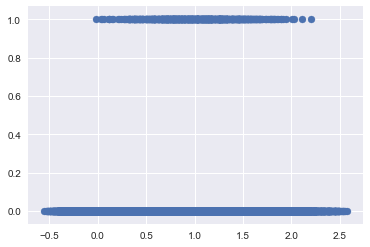

In [119]:
plt.scatter(closure_similarity, y_test)
plt.show()

# Scoring the closing triangles - v2

In v2 we use pairwise similarity of edges that constitute a triangle. The results a disappointing as well.

In [195]:
from sklearn.metrics import average_precision_score, roc_auc_score, auc, f1_score
closure_similarity = []
for t in tqdm_notebook(open_train):
    similarity_scores = []
    triangle_edges = [",".join([str(u), str(v)]) for u,v in itertools.combinations(t,2)]
    for e1,e2 in itertools.combinations(triangle_edges,2):
        if e1 in model.wv.vocab and e2 in model.wv.vocab:
            similarity_scores.append(model.wv.similarity(e1,e2))
        else:
            similarity_scores.append(0)
    closure_similarity.append(np.sum(similarity_scores))
  
print(len(closure_similarity))


80447


AUCPR RND: 0.00851492286847241 | AUCPR S2V: 0.01035342725037779
Ratio as in Kleinberg --  AUCPR S2V/AUCPR RND : 1.2159155649797695


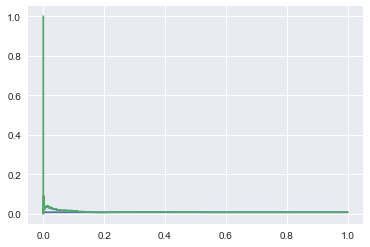

In [198]:
s2v_precision, s2v_recall, _ = precision_recall_curve(y_test, closure_similarity)

p = len([y for y in y_test if y == 1])/len(y_test)
rnd_precision = [p]*len(s2v_recall)

s2v_precision, s2v_recall = s2v_precision[::-1], s2v_recall[::-1]

aucpr_rnd = auc(s2v_recall, rnd_precision)
aucpr_s2v = auc(s2v_recall, s2v_precision)

print("AUCPR RND: {} | AUCPR S2V: {}".format(aucpr_rnd, aucpr_s2v))
kleinberg_ratio = aucpr_s2v/aucpr_rnd
print("Ratio as in Kleinberg --  AUCPR S2V/AUCPR RND :", kleinberg_ratio)

plt.plot(s2v_recall, rnd_precision)
plt.plot(s2v_recall, s2v_precision)
plt.show()

In [137]:
for clos_sim, y_t in list(zip(closure_similarity,y_test)):
    if clos_sim > 2.3:
        print(round(clos_sim, 2), y_t)

2.42 0
2.37 0
2.32 0
2.31 0
2.32 0
2.58 0
2.43 0
2.41 0
2.46 0
2.34 0
2.43 0
2.34 0
2.41 0
2.58 0
2.43 0
2.53 0
2.36 1
2.61 0
2.31 0
2.53 0
2.34 0
2.37 0
2.34 0
2.47 0
2.5 0
2.33 0
2.38 0
2.3 0
2.38 0
2.3 0
2.45 0
2.34 0
2.49 0
2.33 0
2.42 0
2.34 0
2.43 0
2.33 0
2.4 0
2.49 0
2.3 0
2.54 0
2.42 0
2.43 0
2.41 0
2.31 0
2.32 0
2.36 0
2.46 0
2.41 0
2.32 0
2.38 0
2.46 0
2.33 0
2.32 0
2.36 0
2.49 0
2.32 0
2.4 0
2.55 0
2.59 0
2.31 0
2.35 0
2.38 0
2.32 0
2.33 0
2.43 0


# Plot raw similarity scores in 2D

In [ ]:
from sklearn.metrics import average_precision_score, roc_auc_score, auc, f1_score
closure_similarity = []
for t in tqdm_notebook(open_train):
    similarity_scores = []
    for u,v in itertools.combinations(t,2):
        uf = str(u)
        vf = str(v)
        similarity_scores.append(model.wv.similarity(uf,vf))
    closure_similarity.append(similarity_scores)
  
print(len(closure_similarity))

In [ ]:
for clos_sim, y_t in list(zip(closure_similarity,y_test)):
    if y_t == 1:
        print(clos_sim, y_t)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)
ax.scatter(y,z, marker = ".")
# ax.view_init(30, -45)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
# ax.set_zlabel('Z Label')

plt.show()

# Kleinberg Geometric mean 

In [185]:
from scipy.stats.mstats import gmean

geom_mean_similarity = []
for t in tqdm_notebook(open_train):
    similarity_scores = []
    for u,v in itertools.combinations(t,2):
        similarity_scores.append(len(g_train[u][v]["simplices"]))
    geom_mean_similarity.append(gmean(similarity_scores))

AUCPR RND: 0.00851492286847241 | AUCPR S2V: 0.03841936689574226
Ratio as in Kleinberg --  AUCPR S2V/AUCPR RND : 4.512004100236172


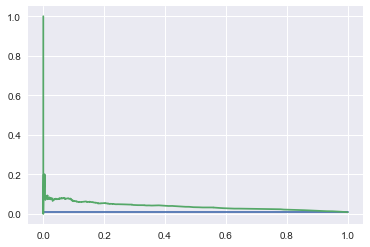

In [193]:
s2v_precision, s2v_recall, _ = precision_recall_curve(y_test, geom_mean_similarity)

p = len([y for y in y_test if y == 1])/len(y_test)
rnd_precision = [p]*len(s2v_recall)

s2v_precision, s2v_recall = s2v_precision[::-1], s2v_recall[::-1]

aucpr_rnd = auc(s2v_recall, rnd_precision)
aucpr_s2v = auc(s2v_recall, s2v_precision)

print("AUCPR RND: {} | AUCPR S2V: {}".format(aucpr_rnd, aucpr_s2v))
kleinberg_ratio = aucpr_s2v/aucpr_rnd
print("Ratio as in Kleinberg --  AUCPR S2V/AUCPR RND :", kleinberg_ratio)

plt.plot(s2v_recall, rnd_precision)
plt.plot(s2v_recall, s2v_precision)
plt.show()

In [191]:
p

0.00851492286847241